In [1]:
import pandas as pd
import scanpy as sc
from scipy.io import mmread
from scipy import sparse
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import h5py
import csv
import os
import loompy
import anndata
from pandas import HDFStore
import collections
import scipy.sparse as sp_sparse
import tables

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [90]:
feature_matrix = mmread("../Data/FeatureMatrix.mtx")

In [4]:
genes = pd.read_csv("../Data/Genes.csv")
positions = pd.read_csv("../Data/SpotPositions.csv")
ScatterPies = pd.read_csv("../Data/SpotClusterMembership.csv")
GeneExpression = pd.read_csv("../Data/ClusterGeneExpression.csv")

In [95]:
feature_matrix = sparse.csc_matrix(feature_matrix)
row_names = positions.iloc[:, 0].values
column_names = genes.iloc[:, 0].values
FeatureMatrix_df = pd.DataFrame.sparse.from_spmatrix(feature_matrix, index=row_names, columns=column_names)
FeatureMatrix_df

,Xkr4,Gm1992,Gm37381,Rp1,Sox17,Gm37323,Mrpl15,Lypla1,Gm37988,Tcea1,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,AC149090.1,CAAA01118383.1,Vmn2r122,CAAA01147332.1
AAACAAGTATCTCCCA-1,2.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2.0,0,0,0
AAACACCAATAACTGC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2.0,0,0
AAACAGAGCGACTCCT-1,0,0,0,0,0,0,2.0,0,0,3.0,...,0,0,0,0,0,0,1.0,1.0,0,0
AAACAGGGTCTATATT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACATTTCCCGGATT-1,1.0,0,0,0,0,0,0,0,0,5.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,0,0,0,0,0,0,1.0,0,0,1.0,...,0,0,0,0,0,0,1.0,0,0,0
TTGTTTCACATCCAGG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTGTTTCATTAGTCTA-1,1.0,0,0,0,0,0,2.0,0,0,5.0,...,0,0,0,0,0,0,3.0,1.0,0,0
TTGTTTCCATACAACT-1,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
GeneExpression

,CellType,Xkr4,Gm1992,Gm37381,Rp1,Sox17,Gm37323,Mrpl15,Lypla1,Gm37988,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,AC149090.1,CAAA01118383.1,Vmn2r122,CAAA01147332.1
0,X1,0.016405,1.388843e-20,3.720076e-41,4.444050e-04,0.004436,3.720076e-41,0.040912,2.270677e-18,0.005500,...,3.720076e-41,3.720076e-41,3.720076e-41,3.720076e-41,3.720076e-41,3.720076e-41,0.009972,0.018385,3.720076e-41,3.510728e-20
1,X2,0.014320,8.828156e-07,3.720076e-41,6.510778e-04,0.003817,3.720076e-41,0.067321,1.154055e-12,0.000241,...,3.720076e-41,3.720076e-41,3.720076e-41,3.720076e-41,3.720076e-41,3.720076e-41,0.118232,0.014748,3.720076e-41,2.806644e-07
2,X3,0.003112,8.383861e-09,3.720076e-41,6.856137e-08,0.001293,3.720076e-41,0.090125,6.120243e-07,0.000222,...,3.720076e-41,3.720076e-41,3.720076e-41,3.720076e-41,3.720076e-41,3.720076e-41,0.147823,0.001430,3.720076e-41,2.232175e-11
3,X4,0.075535,1.637971e-14,3.720076e-41,6.809215e-09,0.005139,3.720076e-41,0.085865,4.121435e-04,0.002276,...,3.720076e-41,3.720076e-41,3.720076e-41,3.720076e-41,3.720076e-41,3.720076e-41,0.032008,0.013536,3.720076e-41,1.385128e-17
4,X5,0.025530,8.579349e-05,3.720076e-41,8.268434e-04,0.001751,3.720076e-41,0.005068,4.174323e-10,0.005650,...,3.720076e-41,3.720076e-41,3.720076e-41,3.720076e-41,3.720076e-41,3.720076e-41,0.007343,0.004941,3.720076e-41,3.045001e-04
5,X6,0.064216,3.274838e-09,3.720076e-41,5.847912e-08,0.000680,3.720076e-41,0.037951,1.446934e-04,0.001176,...,3.720076e-41,3.720076e-41,3.720076e-41,3.720076e-41,3.720076e-41,3.720076e-41,0.092175,0.018011,3.720076e-41,2.859486e-11
6,X7,0.068413,8.588268e-07,3.720076e-41,2.814397e-06,0.016426,3.720076e-41,0.070429,3.368144e-11,0.000516,...,3.720076e-41,3.720076e-41,3.720076e-41,3.720076e-41,3.720076e-41,3.720076e-41,0.034840,0.008038,3.720076e-41,3.670946e-06
7,X8,0.012984,2.495951e-05,3.720076e-41,1.564230e-05,0.002660,3.720076e-41,0.078010,6.693703e-10,0.003080,...,3.720076e-41,3.720076e-41,3.720076e-41,3.720076e-41,3.720076e-41,3.720076e-41,0.071782,0.014877,3.720076e-41,1.859018e-07
8,X9,0.013116,4.512556e-04,3.720076e-41,2.238530e-06,0.000499,3.720076e-41,0.045882,4.411441e-08,0.000813,...,3.720076e-41,3.720076e-41,3.720076e-41,3.720076e-41,3.720076e-41,3.720076e-41,0.025267,0.023112,3.720076e-41,1.120581e-07


In [55]:
expression_data = pd.DataFrame(
    feature_matrix, index=positions["barcode"], columns=genes["gene"]
)
expression_data.columns.name = None
expression_data

,Xkr4,Gm1992,Gm37381,Rp1,Sox17,Gm37323,Mrpl15,Lypla1,Gm37988,Tcea1,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,AC149090.1,CAAA01118383.1,Vmn2r122,CAAA01147332.1
barcode,,,,,,,,,,,,,,,,,,,,,
AAACAAGTATCTCCCA-1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
AAACACCAATAACTGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
AAACAGAGCGACTCCT-1,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
AAACAGGGTCTATATT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTTCCCGGATT-1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
TTGTTTCACATCCAGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTTCATTAGTCTA-1,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0


In [70]:
merged_df = pd.merge(positions, ScatterPies, on="barcode")
merged_df

,barcode,x,y,radius,X1,X2,X3,X4,X5,X6,X7,X8,X9
0,AAACAAGTATCTCCCA-1,12709.0,10806.0,71.192911,0.176596,0.130452,0.000000,0.277719,0.000000,0.334386,0.000000,0.000000,0.080847
1,AAACACCAATAACTGC-1,3616.0,12513.0,71.192911,0.000000,0.000000,0.000000,0.000000,0.662506,0.000000,0.193410,0.144084,0.000000
2,AAACAGAGCGACTCCT-1,11839.0,3944.0,71.192911,0.000000,0.000000,0.330006,0.000000,0.000000,0.250267,0.000000,0.163155,0.256573
3,AAACAGGGTCTATATT-1,2961.0,10225.0,71.192911,0.000000,0.087536,0.000000,0.000000,0.463777,0.000000,0.237417,0.131194,0.080076
4,AAACATTTCCCGGATT-1,12159.0,12902.0,71.192911,0.197194,0.216818,0.000000,0.126936,0.099019,0.067587,0.292446,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3494,TTGTTGTGTGTCAAGA-1,9974.0,7183.0,71.192911,0.077686,0.000000,0.109485,0.372448,0.095749,0.344632,0.000000,0.000000,0.000000
3495,TTGTTTCACATCCAGG-1,6136.0,12325.0,71.192911,0.055007,0.083465,0.134945,0.000000,0.208435,0.121374,0.000000,0.124215,0.272560
3496,TTGTTTCATTAGTCTA-1,4821.0,12705.0,71.192911,0.000000,0.067899,0.000000,0.000000,0.545618,0.000000,0.161659,0.148889,0.075935
3497,TTGTTTCCATACAACT-1,4495.0,9846.0,71.192911,0.000000,0.000000,0.221199,0.000000,0.171150,0.191596,0.000000,0.175395,0.240660


In [5]:
merged_df.to_csv("../Frontend/src/data/piechart.csv", index=False)

In [10]:
# find rows where all values in columns X1-X9 are not 0
filter_df = merged_df[
    (merged_df[["X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "X9"]] != 0).all(axis=1)
]
filter_df

,barcode,x,y,radius,X1,X2,X3,X4,X5,X6,X7,X8,X9
453,AGATAACTTCAGGGCC-1,6359.0,7370.0,71.192911,0.149578,0.090838,0.066249,0.054326,0.236025,0.091684,0.059067,0.159360,0.092872
2033,GCCTATAGTGTCAGGG-1,11508.0,6803.0,71.192911,0.096661,0.109013,0.063389,0.107851,0.308025,0.129497,0.068907,0.052388,0.064270
2213,GGCACTCCACTGGGCA-1,6578.0,7751.0,71.192911,0.092856,0.097069,0.055163,0.063332,0.304833,0.075148,0.060642,0.156100,0.094857
2370,GTAATAAAGGGCTCCC-1,12822.0,7185.0,71.192911,0.053117,0.153904,0.051398,0.070595,0.328283,0.076743,0.112094,0.078818,0.075047
2468,GTGAAGCCGTATAGTC-1,13262.0,5280.0,71.192911,0.373724,0.122477,0.078600,0.061449,0.118235,0.059094,0.053357,0.081445,0.051620
2554,GTTCGTCTGGGTCCCT-1,14576.0,5281.0,71.192911,0.130957,0.054208,0.101681,0.067767,0.247992,0.176499,0.091569,0.075410,0.053918
2835,TCACAGGTTATTGGGC-1,6797.0,7370.0,71.192911,0.084002,0.155032,0.066182,0.076723,0.212137,0.075990,0.072791,0.159356,0.097787
2902,TCCGAAGTAGTCACCA-1,13591.0,3946.0,71.192911,0.105235,0.050853,0.070518,0.079200,0.217468,0.238641,0.086357,0.099968,0.051759
3108,TGATCTCCGGCGCCAG-1,7017.0,6608.0,71.192911,0.108314,0.130011,0.139281,0.057951,0.096534,0.078358,0.123449,0.141784,0.124318


In [6]:
position_merged_df = pd.merge(positions, expression_data, on="barcode")
position_merged_df

,barcode,x,y,radius,Xkr4,Gm1992,Gm37381,Rp1,Sox17,Gm37323,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,AC149090.1,CAAA01118383.1,Vmn2r122,CAAA01147332.1
0,AAACAAGTATCTCCCA-1,12709.0,10806.0,71.192911,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
1,AAACACCAATAACTGC-1,3616.0,12513.0,71.192911,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
2,AAACAGAGCGACTCCT-1,11839.0,3944.0,71.192911,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,AAACAGGGTCTATATT-1,2961.0,10225.0,71.192911,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AAACATTTCCCGGATT-1,12159.0,12902.0,71.192911,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3494,TTGTTGTGTGTCAAGA-1,9974.0,7183.0,71.192911,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3495,TTGTTTCACATCCAGG-1,6136.0,12325.0,71.192911,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3496,TTGTTTCATTAGTCTA-1,4821.0,12705.0,71.192911,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0
3497,TTGTTTCCATACAACT-1,4495.0,9846.0,71.192911,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


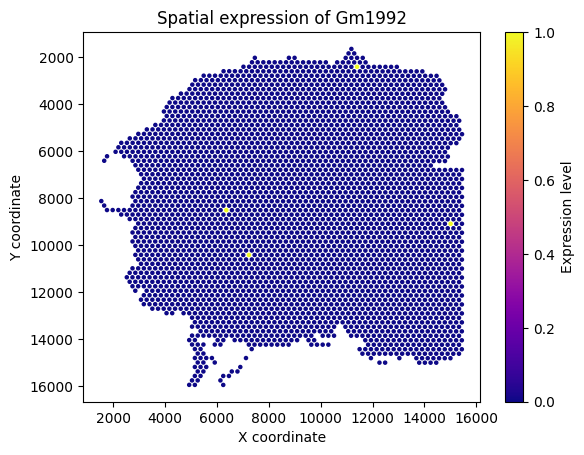

In [99]:
# WRONG
# Select a gene to visualize
gene_of_interest = "Gm1992"

# Create a scatter plot of the expression of the gene of interest
plt.scatter(
    positions["x"],
    positions["y"],
    c=FeatureMatrix_df[gene_of_interest],
    cmap="plasma",
    s=5,
)
plt.colorbar(label="Expression level")
plt.title(f"Spatial expression of {gene_of_interest}")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")

plt.gca().invert_yaxis()
plt.show()

In [12]:
# Generate angles for each spot
spotDiameter = 142.38582253945773
scalef = 0.03479471
radius = spotDiameter * scalef / 2


# Define the equation to solve
def equation(x, a, r):
    return x - (90 * a + (90 / (4 * np.pi * r**2)) * np.sin(2 * x))


# Function to solve for x
def solve_for_x(a, r=radius):
    if a == 0:
        return 0
    x0 = 5  # Initial guess
    x_solution = fsolve(equation, x0, args=(a, r))
    return x_solution[0]


# Calculate the new DataFrame with x values
def calculate_x_values(df, r=radius):
    result_df = df.copy()
    for index, row in df.iterrows():
        cumulative_sum = 0
        for i in range(1, 10):
            a_value = row[f"X{i}"]
            cumulative_sum += a_value
            if a_value == 0:
                result_df.loc[index, f"X{i}_angle"] = 0
            else:
                result_df.loc[index, f"X{i}_angle"] = solve_for_x(cumulative_sum, r)
    return result_df


# Apply the function to the DataFrame
result_df = calculate_x_values(merged_df)

result_df

/Users/siyuanzhao/anaconda3/envs/VDS/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/siyuanzhao/anaconda3/envs/VDS/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/siyuanzhao/anaconda3/envs/VDS/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/siyuanzhao/anaconda3/envs/VDS/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten itera

,barcode,x,y,radius,X1,X2,X3,X4,X5,X6,...,X9,X1_angle,X2_angle,X3_angle,X4_angle,X5_angle,X6_angle,X7_angle,X8_angle,X9_angle
0,AAACAAGTATCTCCCA-1,12709.0,10806.0,71.192911,0.176596,0.130452,0.000000,0.277719,0.000000,0.334386,...,0.080847,16.820188,26.993931,0.000000,53.978778,0.000000,83.091811,0.000000,0.000000,89.676025
1,AAACACCAATAACTGC-1,3616.0,12513.0,71.192911,0.000000,0.000000,0.000000,0.000000,0.662506,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,59.738874,0.000000,76.988042,89.676025,0.000000
2,AAACAGAGCGACTCCT-1,11839.0,3944.0,71.192911,0.000000,0.000000,0.330006,0.000000,0.000000,0.250267,...,0.256573,0.000000,0.000000,29.801718,0.000000,0.000000,51.953472,0.000000,67.350181,89.676025
3,AAACAGGGTCTATATT-1,2961.0,10225.0,71.192911,0.000000,0.087536,0.000000,0.000000,0.463777,0.000000,...,0.080076,0.000000,5.718967,0.000000,0.000000,48.982613,0.000000,72.820907,83.113290,89.676025
4,AAACATTTCCCGGATT-1,12159.0,12902.0,71.192911,0.197194,0.216818,0.000000,0.126936,0.099019,0.067587,...,0.000000,19.413138,36.489456,0.000000,48.691869,57.960914,62.267598,89.676025,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3494,TTGTTGTGTGTCAAGA-1,9974.0,7183.0,71.192911,0.077686,0.000000,0.109485,0.372448,0.095749,0.344632,...,0.000000,5.718933,0.000000,15.143786,50.189846,58.387339,89.676025,0.000000,0.000000,0.000000
3495,TTGTTTCACATCCAGG-1,6136.0,12325.0,71.192911,0.055007,0.083465,0.134945,0.000000,0.208435,0.121374,...,0.272560,4.784005,12.644824,25.696771,0.000000,44.546424,52.843143,0.000000,64.740166,89.676025
3496,TTGTTTCATTAGTCTA-1,4821.0,12705.0,71.192911,0.000000,0.067899,0.000000,0.000000,0.545618,0.000000,...,0.075935,0.000000,5.176513,0.000000,0.000000,55.049615,0.000000,70.399101,83.226303,89.676025
3497,TTGTTTCCATACAACT-1,4495.0,9846.0,71.192911,0.000000,0.000000,0.221199,0.000000,0.171150,0.191596,...,0.240660,0.000000,0.000000,18.285625,0.000000,35.875927,53.970181,0.000000,67.789916,89.676025


In [13]:
result_df.to_csv("../Frontend/src/data/kosaraChart.csv", index=False)

In [6]:
expression_data.to_csv("../Frontend/src/data/expressionData.csv", index=False)

In [41]:
with h5py.File("../Data/Filtered_feature_bc_matrix.h5", "r") as file:
    # genes = [name.decode('utf-8') for name in file['matrix/features/name'][:]]
    genes = pd.read_csv("../Data/Genes.csv")
    genes = list(genes["gene"])
    barcodes = [barcode.decode("utf-8") for barcode in file["matrix/barcodes"][:]]

    data = file["matrix/data"][:]
    indices = file["matrix/indices"][:]
    indptr = file["matrix/indptr"][:]
    shape = file["matrix/shape"][:]  # (31053, 3499)

    print("Data length:", len(data))
    print("Indices length:", len(indices))
    print("Indptr length:", len(indptr), "Expected:", shape[0] + 1)
    print("Shape:", shape)

    matrix = sparse.csc_matrix((data, indices, indptr), shape=shape)

    df = pd.DataFrame(matrix.toarray(), index=genes, columns=barcodes).transpose()
    # df.fillna(0, inplace=True)

    df.to_csv("output.csv")

df

Data length: 13742662
Indices length: 13742662
Indptr length: 3500 Expected: 31054
Shape: [31053  3499]


,Xkr4,Gm1992,Gm37381,Rp1,Sox17,Gm37323,Mrpl15,Lypla1,Gm37988,Tcea1,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,AC149090.1,CAAA01118383.1,Vmn2r122,CAAA01147332.1
AAACAAGTATCTCCCA-1,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACACCAATAACTGC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACAGAGCGACTCCT-1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,2,0,0,0
AAACAGGGTCTATATT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACATTTCCCGGATT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
TTGTTTCACATCCAGG-1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
TTGTTTCATTAGTCTA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTGTTTCCATACAACT-1,0,0,0,0,0,0,3,0,0,3,...,0,0,0,0,0,0,1,0,0,0


In [33]:
# check dupilcate gene names
adata = sc.read_10x_h5("../Data/Filtered_feature_bc_matrix.h5")

umi_counts = adata.to_df()

umi_counts.reset_index(inplace=True)
gene_names = adata.var_names

duplicate_gene_names = gene_names[gene_names.duplicated()]
print(duplicate_gene_names)

Index(['Sept2', 'Kiss1', 'Zc3h11a', 'Gm16701', 'Hoxd4', 'Gm2464', 'Vmn2r7',
       'Gm28710', 'Jakmip1', 'Gm16499', 'Zfp865', 'Olfr290', 'Aldoa', 'Dpep2',
       'St6galnac2', 'Hgs', 'Vmn1r216', 'Nnt', 'Gm35558', 'Ighv5-8',
       'Ighv1-13', 'Gcat', 'Pick1', 'Atp5o', 'Pcdha11', 'Nudt8', 'Lbhd1',
       'Ints5', 'Ccl21b', 'Il11ra2', 'Ccl21c', 'Gm3286', 'Ccl27', 'Il11ra2',
       'Ccl19', 'Ccl21a'],
      dtype='object') ////


/Users/siyuanzhao/anaconda3/envs/VDS/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/siyuanzhao/anaconda3/envs/VDS/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [2]:
# Using scanpy to read the h5 file
adata = sc.read_10x_h5("../Data/Filtered_feature_bc_matrix.h5")

adata.var_names_make_unique()

umi_counts = adata.to_df()

# umi_counts.reset_index(inplace=True)

# geneList = adata.var_names.tolist()
# gene_df = pd.DataFrame(geneList, columns=['Gene'])
# umi_counts.columns = ['barcode'] + geneList

umi_counts
# gene_df.to_csv('../Frontend/src/data/genes.csv', index=False)
# umi_counts.to_csv('../Frontend/src/data/umiCounts.csv', index=False)

/Users/siyuanzhao/anaconda3/envs/VDS/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/siyuanzhao/anaconda3/envs/VDS/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


,Xkr4,Gm1992,Gm37381,Rp1,Sox17,Gm37323,Mrpl15,Lypla1,Gm37988,Tcea1,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,AC149090.1,CAAA01118383.1,Vmn2r122,CAAA01147332.1
AAACAAGTATCTCCCA-1,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACACCAATAACTGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACAGAGCGACTCCT-1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
AAACAGGGTCTATATT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTTCCCGGATT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
TTGTTTCACATCCAGG-1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
TTGTTTCATTAGTCTA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTGTTTCCATACAACT-1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [4]:
total_counts = umi_counts.sum(axis=1)


pandas.core.series.Series

In [87]:
# Check if the gene names in the two files are the same
df_test_1 = gene_df["Gene"]
df_test_2 = genes["gene"]

diff_from_df1 = df_test_1[~df_test_1.isin(df_test_2)]
diff_from_df2 = df_test_2[~df_test_2.isin(df_test_1)]

print("Values in file1 not in file2:")
print(diff_from_df1)

print("\nValues in file2 not in file1:")
print(diff_from_df2)

Values in file1 not in file2:
Series([], Name: Gene, dtype: object)

Values in file2 not in file1:
Series([], Name: gene, dtype: object)


In [23]:
# Read the loom file
with loompy.connect("../Data/parsing_output.loom") as ds:
    expression_df = pd.DataFrame(
        data=ds[:, :], columns=ds.ca["CellID"], index=ds.ra["Gene"]
    )

gene_list = expression_df.index.tolist()
gene_df = pd.DataFrame(gene_list, columns=["Gene"])

gene_df.to_csv("gene_list.csv", index=False)

In [71]:
CountMatrix = collections.namedtuple(
    "CountMatrix", ["feature_ref", "barcodes", "matrix"]
)

def get_matrix_from_h5(filename):
    with tables.open_file(filename, "r") as f:
        mat_group = f.get_node(f.root, "matrix")
        barcodes = f.get_node(mat_group, "barcodes").read()
        data = getattr(mat_group, "data").read()
        indices = getattr(mat_group, "indices").read()
        indptr = getattr(mat_group, "indptr").read()
        shape = getattr(mat_group, "shape").read()
        matrix = sp_sparse.csc_matrix((data, indices, indptr), shape=shape)

        feature_ref = {}
        feature_group = f.get_node(mat_group, "features")
        feature_ids = getattr(feature_group, "id").read()
        feature_names = getattr(feature_group, "name").read()
        feature_types = getattr(feature_group, "feature_type").read()
        feature_ref["id"] = feature_ids
        feature_ref["name"] = feature_names
        feature_ref["feature_type"] = feature_types
        tag_keys = getattr(feature_group, "_all_tag_keys").read()
        for key in tag_keys:
            key = key.decode("utf-8")
            feature_ref[key] = getattr(feature_group, key).read()

        return CountMatrix(feature_ref, barcodes, matrix)


filtered_matrix_h5 = "../Data/Filtered_feature_bc_matrix.h5"
filtered_feature_bc_matrix = get_matrix_from_h5(filtered_matrix_h5)
filtered_feature_bc_matrix

CountMatrix(feature_ref={'id': array([b'ENSMUSG00000051951', b'ENSMUSG00000089699',
       b'ENSMUSG00000102343', ..., b'ENSMUSG00000063897',
       b'ENSMUSG00000096730', b'ENSMUSG00000095742'], dtype='|S18'), 'name': array([b'Xkr4', b'Gm1992', b'Gm37381', ..., b'CAAA01118383.1',
       b'Vmn2r122', b'CAAA01147332.1'], dtype='|S16'), 'feature_type': array([b'Gene Expression', b'Gene Expression', b'Gene Expression', ...,
       b'Gene Expression', b'Gene Expression', b'Gene Expression'],
      dtype='|S15'), 'genome': array([b'mm10-3.0.0_premrna', b'mm10-3.0.0_premrna',
       b'mm10-3.0.0_premrna', ..., b'mm10-3.0.0_premrna',
       b'mm10-3.0.0_premrna', b'mm10-3.0.0_premrna'], dtype='|S18')}, barcodes=array([b'AAACAAGTATCTCCCA-1', b'AAACACCAATAACTGC-1',
       b'AAACAGAGCGACTCCT-1', ..., b'TTGTTTCATTAGTCTA-1',
       b'TTGTTTCCATACAACT-1', b'TTGTTTGTGTAAATTC-1'], dtype='|S18'), matrix=<31053x3499 sparse matrix of type '<class 'numpy.int32'>'
	with 13742662 stored elements in Compres

In [81]:
feature_ref_df = pd.DataFrame({
    key: [item.decode("utf-8") if isinstance(item, bytes) else item for item in value]
    for key, value in filtered_feature_bc_matrix.feature_ref.items()
})

barcodes_df = pd.DataFrame(filtered_feature_bc_matrix.barcodes, columns=["barcodes"])

matrix_df = pd.DataFrame.sparse.from_spmatrix(
    filtered_feature_bc_matrix.matrix,
    index=feature_ref_df["name"],
    columns=[barcode.decode("utf-8") for barcode in filtered_feature_bc_matrix.barcodes]
)
duplicate_names = feature_ref_df['name'][feature_ref_df['name'].duplicated(keep=False)]

duplicate_names_list = duplicate_names.tolist()
duplicate_names_list
# barcodes_df
# matrix_test = matrix_df.T
# matrix_test

['Sept2',
 'Sept2',
 'Kiss1',
 'Kiss1',
 'Zc3h11a',
 'Zc3h11a',
 'Gm16701',
 'Gm16701',
 'Hoxd4',
 'Hoxd4',
 'Gm2464',
 'Gm2464',
 'Vmn2r7',
 'Vmn2r7',
 'Ccl21b',
 'Il11ra2',
 'Ccl19',
 'Ccl21a',
 'Gm28710',
 'Gm28710',
 'Jakmip1',
 'Jakmip1',
 'Gm3286',
 'Gm16499',
 'Gm16499',
 'Zfp865',
 'Zfp865',
 'Olfr290',
 'Olfr290',
 'Aldoa',
 'Aldoa',
 'Dpep2',
 'Dpep2',
 'St6galnac2',
 'St6galnac2',
 'Hgs',
 'Hgs',
 'Vmn1r216',
 'Vmn1r216',
 'Nnt',
 'Nnt',
 'Gm35558',
 'Gm35558',
 'Ighv5-8',
 'Ighv5-8',
 'Ighv1-13',
 'Ighv1-13',
 'Gcat',
 'Gcat',
 'Pick1',
 'Pick1',
 'Atp5o',
 'Atp5o',
 'Pcdha11',
 'Pcdha11',
 'Nudt8',
 'Nudt8',
 'Lbhd1',
 'Lbhd1',
 'Ints5',
 'Ints5',
 'Ccl21b',
 'Ccl21c',
 'Il11ra2',
 'Ccl27',
 'Ccl21c',
 'Gm3286',
 'Ccl27',
 'Il11ra2',
 'Ccl19',
 'Ccl21a']

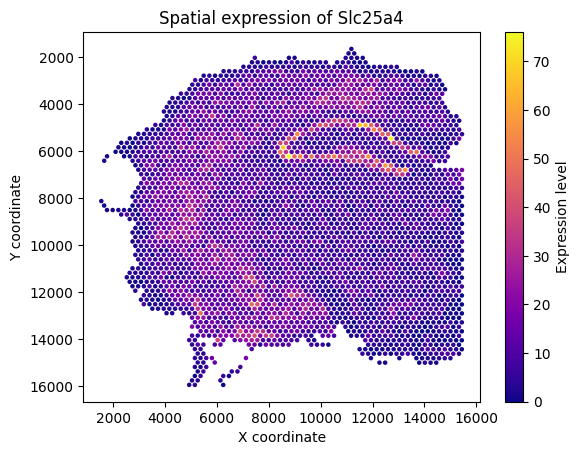

In [98]:
# Viewing the gene expression of a gene of interest
gene_of_interest = "Slc25a4"

# Create a scatter plot of the expression of the gene of interest
plt.scatter(
    positions["x"], positions["y"], c=umi_counts[gene_of_interest], cmap="plasma", s=5
)
plt.colorbar(label="Expression level")
plt.title(f"Spatial expression of {gene_of_interest}")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")

plt.gca().invert_yaxis()
plt.show()